# ECG Heartbeat Categoritzation Dataset (PTB)

## Download and parse data from Kaggle

Download from https://www.kaggle.com/datasets/shayanfazeli/heartbeat and unzip to data/mitbih

Sample: file structure in data/mitbih

```
mitbih
  ├── mitbih_test.csv
  ├── mitbih_train.csv
  ├── ptbdb_abnormal.csv
  └── ptbdb_normal.csv
```

## Setup Data

In [1]:
import numpy as np
import pandas as pd
import time
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

root_folder = Path(input("Enter the folder path: (leave blank for default)")) # leave blank for default
assert root_folder.exists(), "The folder does not exist"
assert (root_folder + "data/mitbih/ptbdb_abnormal.csv").exists(), "The folder does not exist"

## Load train and test data

In [3]:
# 0: normal, 1: abnormal
abnormal_df = pd.read_csv(root_folder + "data/mitbih/ptbdb_abnormal.csv", header = None)
normal_df = pd.read_csv(root_folder + "data/mitbih/ptbdb_normal.csv", header = None)

X = pd.concat((normal_df, abnormal_df))
temp_train, temp_test = train_test_split(X.sample(frac=1), test_size=0.2, random_state=123)

train_data = temp_train.to_numpy()
test_data = temp_test.to_numpy()

train_x, train_y = train_data[:, :-1], train_data[:, -1].astype(int)
test_x, test_y = test_data[:, :-1], test_data[:, -1].astype(int)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((11641, 187), (11641,), (2911, 187), (2911,))

## Visualizing Samples

Text(0, 0.5, 'Abnormal beats\u200b')

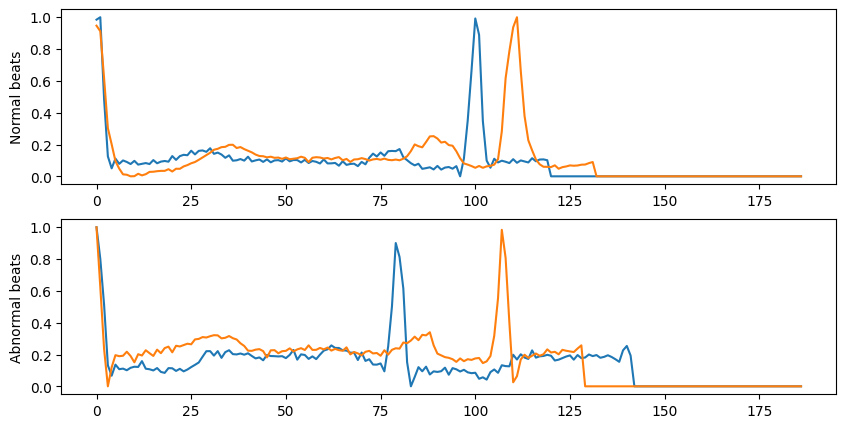

In [ ]:
arr0 = train_x[7]
arr00 = train_x[13]
arr1 = train_x[0]
arr11 = train_x[11636]

fig, ax = plt.subplots(2, figsize=(10,5))
ax[0].plot([i for i in range(len(arr0))], arr0)
ax[0].plot([i for i in range(len(arr00))], arr00)
ax[0].set_ylabel('Normal beats​', fontsize=10)
ax[1].plot([i for i in range(len(arr1))], arr1)
ax[1].plot([i for i in range(len(arr11))], arr11)
ax[1].set_ylabel('Abnormal beats​', fontsize=10)

# Pinecone

In [4]:
!pip install -qU "pinecone-client[grpc]"==2.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.0/223.0 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.0/218.0 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.0/218.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.7/211.7 kB 20.3 MB/s eta 0:00:00
ERROR: pip's dep

In [5]:
import os
import pinecone
import json

try:
    pinecone_config = json.load(open(root_folder + 'pinecone.config.json'))
except FileNotFoundError as e:
    print("Pinecone.json not found. Please copy ./pinecone-template.config.json and fill in the values.")
    raise e

# get api key from app.pinecone.io
PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY') or pinecone_config['PINECONE_API_KEY']
# find your environment next to the api key in pinecone console
PINECONE_ENV = os.environ.get('PINECONE_ENVIRONMENT') or pinecone_config['PINECONE_ENVIRONMENT']

pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_ENV
)

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Get or create an index

In [6]:
def get_pinecone_index(index_name, metric="cosine"):
    assert metric in ['cosine', 'euclidean', 'dotproduct']
    # only create index if it doesn't exist
    new_index = False
    if index_name not in pinecone.list_indexes():
        pinecone.create_index(
            name=index_name,
            dimension=train_x.shape[1],
            metric=metric
        )
        # wait a moment for the index to be fully initialized
        time.sleep(1)
        new_index = True


    # now connect to the index
    index = pinecone.GRPCIndex(index_name)
    return index, new_index

index_name = 'search-ptb'
index, new_index = get_pinecone_index(index_name, 'euclidean')
index, new_index

(<pinecone.core.grpc.index_grpc.GRPCIndex at 0x7d03b67e9000>, False)

## Upload vectors if new index

In [7]:
def upload_vector(train_x, train_y):
    print(len(train_x), len(train_y))

    temp = {'id': [], 'embeddings': [], 'metadata': []}
    for i in range(train_x.shape[0]):
        temp['id'].append(i)
        temp['embeddings'].append(train_x[i])
        tempdict = dict()
        tempdict['label'] = str(train_y[i])
        temp['metadata'].append(tempdict)

    train_df_vec = pd.DataFrame.from_dict(temp)

    def chunker(seq, size):
        'Yields a series of slices of the original iterable, up to the limit of what size is.'
        for pos in range(0, len(seq), size):
            yield seq.iloc[pos:pos + size]

    def convert_data(chunk):
        'Converts a pandas dataframe to be a simple list of tuples, formatted how the `upsert()` method in the Pinecone Python client expects.'
        data = []
        for i in chunk.to_dict('records'):
            if 'metadata' in i:
                data.append((str(i['id']),i['embeddings'],i['metadata']))
            else:
                data.append((str(i['id']),i['embeddings']))
        return data


    for chunk in chunker(train_df_vec, 100):
        index.upsert(vectors=convert_data(chunk))

if new_index:
    upload_vector(train_x, train_y)

## Run Test

In [12]:
from collections import defaultdict
import json

def run_test(index, test_x, test_y, file='total_results'):

    def query(res):
        label_count = defaultdict(int)
        for match in res['matches']:
            label_count[match.metadata['label']] += 1

        max_count = max(label_count.values())  # Find the maximum count value
        max_keys = [key for key, count in label_count.items() if count == max_count]  # Find all keys with the max count

        return label_count, max_keys, res['matches'][0].metadata['label']

    total, top1, correct = 0, 0, 0
    total_results = []
    total_query = []

    matrix = {}
    for k in set(test_y):
        matrix[str(k)] = {}
        for j in set(test_y):
            matrix[str(k)][str(j)] = 0

    for i, test_1 in enumerate(test_x):
        res = index.query(
            vector=test_1,
            top_k=10,
            include_metadata=True
        )
        label = str(test_y[i])
        total_results.append((label, res.to_dict()['matches']))
        if len(res['matches']) == 10:
            total += 1
            q = query(res)
            total_query.append(q)
            matrix[label][str(q[2])] += 1
            if str(q[2]) == label:
                top1 += 1
            if str(q[1][0]) == label:
                correct += 1

    print(f'Total results: {total}')
    print(f"Top1: {top1}")
    print(f"Correct: {correct}")
    print(f"Top 1 Accuracy: {top1 / total * 100:.6f}%")
    print(f"Top 10 Accuracy: {correct / total * 100:.6f}%")
    # json.dump(total_results, open(root_folder + (file + ".json"), 'w'))
    return (total, top1, correct), (top1 / total * 100, correct / total * 100), matrix


index, _ = get_pinecone_index(index_name)
res, acc, matrix = run_test(index, test_x, test_y, file='total_results')

Total results: 2911
Top1: 2894
Correct: 2762
Top 1 Accuracy: 99.416008%
Top 10 Accuracy: 94.881484%


## Plot Confusion Matrix

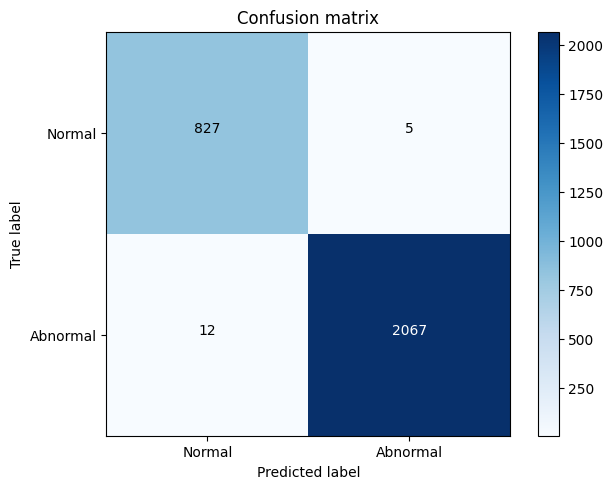

In [13]:
import itertools

# Extracting labels and counts
label_index = {"Normal": 0, "Abnormal": 1}
labels = label_index.keys()
confusion_matrix = np.array([[matrix[str(label_index[row])][str(label_index[col])] for col in labels] for row in labels])

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes=labels)
plt.show()

# Connect to Apple Health Database

1. In Apple Health app, click profile icon and scroll down to the end.
2. Click "Export All Health Data" button and copy the `export.zip` to `data/` folder
3. Unzip it  

Sample data folder:
```
apple_health_export
├── electrocardiograms
│   ├── ecg_2021-10-15_1.csv
│   ├── ecg_2021-10-15_2.csv
│   ├── ................
│   └── ecg_2022-10-23.csv
├── export_cda.xml
├── export.xml
└── workout-routes
    ├── route_2021-10-21_6.17pm.gpx
    ├── route_2022-05-05_8.49pm.gpx
    ├── ................
    └── route_2023-11-07_5.31pm.gpx
```

In [18]:
assert os.path.exists(root_folder + "data/apple_health_export/electrocardiograms"), "The ECG record folder does not exist"

ecg_folder = Path(root_folder + "data/apple_health_export/electrocardiograms")
ecg_files = list(ecg_folder.glob('*.csv'))

print(f"Found {len(ecg_files)} ECG records")

Found 5 ECG records


## Analyze the last ECG record (most recent)

In [19]:
def parse_ecg(ecg_file):
    last_ecg = pd.read_csv(ecg_file, header=None)
    test_x = last_ecg[10:].to_numpy().astype(np.float32)[:,0]
    profile = {
        "name": last_ecg.iloc[0][1],
        "birthday": last_ecg.iloc[1][1],
        "date": last_ecg.iloc[2][1],
        "class": last_ecg.iloc[3][1],
        "symptoms": last_ecg.iloc[4][1],
        "version": last_ecg.iloc[5][1],
        "device": last_ecg.iloc[6][1],
        "sample_rate": int(last_ecg.iloc[7][1].split(" ")[0]),
        "lead": last_ecg.iloc[8][1],
        "unit": last_ecg.iloc[9][1],
    }
    return test_x, profile

test_apple, profile = parse_ecg(sorted(ecg_files)[-1])

## Visualize data

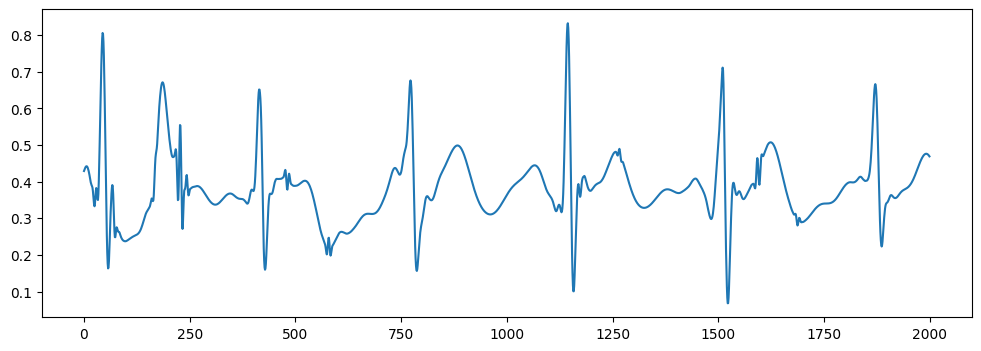

In [20]:
norm_test_apple = (test_apple - test_apple.min()) / (test_apple.max() - test_apple.min())
plt.figure(figsize=(12, 4))
plt.plot(norm_test_apple[:2000])

## Split beats

In [ ]:
!pip install biosppy

In [22]:
from biosppy.signals import ecg
from scipy.signal import resample

def split_beat(signal, input_fs=512, output_fs=125, pad=60, padding_size=187):
    out = ecg.ecg(signal=signal, sampling_rate=profile['sample_rate'], show=False)
    rpeaks = np.zeros_like(signal, dtype='float')
    rpeaks[out['rpeaks']] = 1.0

    # Split into individual heartbeats. For each heartbeat
    # record, append classification (normal/abnormal).
    beats = np.split(signal, out['rpeaks'])
    final_beats = []
    for idx, idxval in enumerate(out['rpeaks']):
        firstround = idx == 0
        lastround = idx == len(beats) - 1

        # Skip first and last beat.
        if (firstround or lastround):
            continue

        # Append some extra readings from next beat.
        beats[idx] = np.append(beats[idx], beats[idx+1][:pad])

        # Normalize the readings to a 0-1 range for ML purposes.
        beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

        # Resample from 360Hz to 125Hz
        newsize = int((beats[idx].size * output_fs / input_fs) + 0.5)
        beats[idx] = resample(beats[idx], newsize)

        # Skipping records that are too long.
        if (beats[idx].size > 187 + pad):
            continue
        elif (beats[idx].size > 187):
            beats[idx] = beats[idx][:187]

        # Pad with zeroes.
        zerocount = padding_size - beats[idx].size
        beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))
        final_beats.append(beats[idx])

    return np.array(final_beats)

beats = split_beat(test_apple, pad=58)

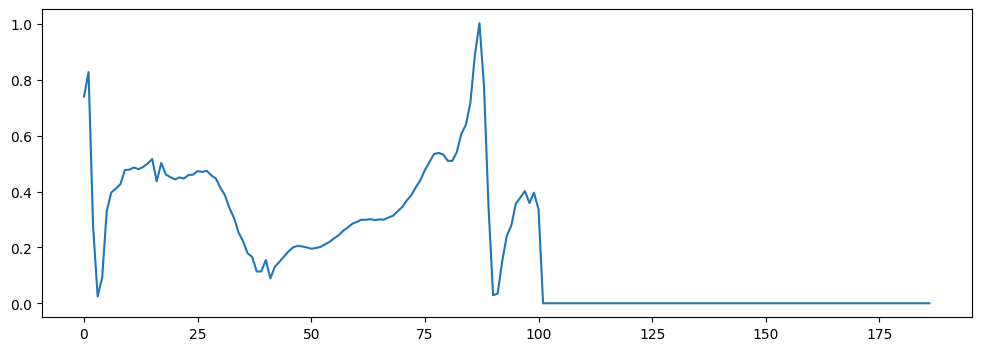

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(beats[0])

## Predict beat

In [24]:
res = index.query(
    vector=beats[0],
    top_k=10,
    include_metadata=True
)
res.matches[0].metadata

{'label': '0'}